# Text Classification CNN Baseline Model
## Microaggression Detection using Convolutional Neural Networks

## Load libraries

In [ ]:
!pip install -q pandas numpy scikit-learn tensorflow optuna gensim

In [ ]:
# data analysis
import pandas as pd
import numpy as np
import pickle
import datasets # Added for loading 'collections datasets'

# exploratory analysis
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image, display
import plotly
from collections import Counter
import re

# text processing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tuning model
import optuna
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Dense, Dropout, Embedding, Conv1D,
                                     GlobalMaxPooling1D, GlobalAveragePooling1D,
                                     MaxPooling1D, Flatten, Input, Concatenate,
                                     SpatialDropout1D, BatchNormalization)
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                            f1_score, confusion_matrix, classification_report)

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Mount google drive
from google.colab import drive

# better display for dataframes
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Plotting
from matplotlib import pyplot as plt

### GPU Configuration ###
print("="*60)
print("GPU/CPU Configuration")
print("="*60)

# Choose device
USE_GPU = True  # Set to False to force CPU usage

def configure_gpu():
    """Configure TensorFlow to use GPU or CPU"""

    # Check if GPU is available
    gpus = tf.config.list_physical_devices('GPU')
    cpus = tf.config.list_physical_devices('CPU')

    print(f"Available devices:")
    print(f"  GPUs: {len(gpus)}")
    print(f"  CPUs: {len(cpus)}")

    if gpus and USE_GPU:
        try:
            # Enable memory growth to avoid allocating all GPU memory at once
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)

            # Set GPU as preferred device
            tf.config.set_visible_devices(gpus, 'GPU')

            print(f"\n GPU Configuration:")
            print(f"  Using GPU: {gpus[0].name}")
            print(f"  Memory growth: Enabled")
            print(f"  TensorFlow version: {tf.__version__}")

            # Test GPU
            with tf.device('/GPU:0'):
                test_tensor = tf.constant([[1.0, 2.0], [3.0, 4.0]])
                print(f"  GPU test successful: {test_tensor.device}")

            return True

        except RuntimeError as e:
            print(f"\n GPU configuration failed: {e}")
            print(" Falling back to CPU...")
            return False

    else:
        # Force CPU usage
        tf.config.set_visible_devices(cpus, 'CPU')
        print(f"\n CPU Configuration:")
        print(f" Using CPU: {cpus[0].name}")
        print(f" TensorFlow version: {tf.__version__}")

        # Test CPU
        with tf.device('/CPU:0'):
            test_tensor = tf.constant([[1.0, 2.0], [3.0, 4.0]])
            print(f"  CPU test successful: {test_tensor.device}")

        return False

# Configure device
GPU_AVAILABLE = configure_gpu()

# Display device info
print(f"\nDevice Summary:")
if GPU_AVAILABLE:
    print(f"Using GPU for training (faster)")
    print(f"Tip: GPU will significantly speed up CNN training")
else:
    print(f"Using CPU for training")
    print(f"Training will be slower but will work on any machine")

print("="*60)

GPU/CPU Configuration
Available devices:
  GPUs: 1
  CPUs: 1

 GPU Configuration:
  Using GPU: /physical_device:GPU:0
  Memory growth: Enabled
  TensorFlow version: 2.19.0
  GPU test successful: /job:localhost/replica:0/task:0/device:GPU:0

Device Summary:
Using GPU for training (faster)
Tip: GPU will significantly speed up CNN training


## Step 1: Data Ingestion

In [ ]:
# Load dataset from the new path
drive.mount('/content/drive')
dataset_base_path = "/content/drive/MyDrive/266_project/balanced_selfMA_SBIC_ds"
print(f"Loading datasets from: {dataset_base_path}")

def load_data_split(base_path, split_name):
    """Loads data split using datasets.load_from_disk and converts to pandas DataFrame."""
    split_path = f"{base_path}/{split_name}"
    df = None
    try:
        print(f"  Trying to load {split_name} from {split_path} using datasets.load_from_disk...")
        dataset = datasets.load_from_disk(split_path)
        df = dataset.to_pandas()
        print(f"  Successfully loaded {split_name} as pandas DataFrame.")
    except Exception as e:
        raise FileNotFoundError(f"Could not load data for split '{split_name}' from {split_path} using datasets.load_from_disk: {e}")

    # Ensure 'cleaned_text' and 'hateful_layer' exist for consistency
    if 'text' in df.columns and 'cleaned_text' not in df.columns:
        df['cleaned_text'] = df['text']
    elif 'speech' in df.columns and 'cleaned_text' not in df.columns: # As seen in microaggressions
        df['cleaned_text'] = df['speech']
    elif 'cleaned_text' not in df.columns:
        print(f"Warning: 'cleaned_text' or 'text'/'speech' column not found in {split_name}. Assuming first string column is text.")
        str_cols = df.select_dtypes(include='object').columns
        if len(str_cols) > 0:
            df['cleaned_text'] = df[str_cols[0]]
            print(f"  Used '{str_cols[0]}' as 'cleaned_text' for {split_name}.")
        else:
            raise ValueError(f"No suitable text column found in {split_name} dataset.")

    if 'label' in df.columns and 'hateful_layer' not in df.columns:
        df.rename(columns={'label': 'hateful_layer'}, inplace=True)
        print(f"  Renamed 'label' column to 'hateful_layer' in {split_name}.")
    elif 'hateful_layer' not in df.columns:
        print(f"Warning: 'hateful_layer' (or 'microaggression label') or 'label' column not found in {split_name}. Assuming target is 'label'.")
        if 'label' in df.columns:
            df.rename(columns={'label': 'hateful_layer'}, inplace=True)
            print(f"  Renamed 'label' column to 'hateful_layer' in {split_name}.")
        else:
            raise ValueError(f"No suitable target column ('hateful_layer' or 'label') found in {split_name} dataset.")

    return df

# --- BEGIN MODIFICATION ---
import os

# Check the contents of the directory
print(f"\nContents of {dataset_base_path}:")
if os.path.exists(dataset_base_path):
    for item in os.listdir(dataset_base_path):
        print(f"  - {item}")
else:
    print(f"Error: Directory {dataset_base_path} not found.")


# The following lines are now uncommented to attempt loading
df_train = load_data_split(dataset_base_path, 'train')
df_val = load_data_split(dataset_base_path, 'validation') # Changed to 'validation'
df_test = load_data_split(dataset_base_path, 'test')

print(f"\nDataset shapes:")
print(f"Train: {df_train.shape}")
print(f"Val: {df_val.shape}")
print(f"Test: {df_test.shape}")

print(f"\nColumn names:")
print(df_train.columns.tolist())

print(f"\nFirst few rows of training data:")
display(df_train.head())

print(f"\nData types:")
print(df_train.dtypes)

print(f"\nTarget variable (microaggression label) distribution in training set:")
print(df_train['hateful_layer'].value_counts().sort_index())

print(f"\nMissing values:")
print(df_train.isnull().sum())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading datasets from: /content/drive/MyDrive/266_project/balanced_selfMA_ds

Contents of /content/drive/MyDrive/266_project/balanced_selfMA_ds:
  - dataset_dict.json
  - train
  - validation
  - test
  Trying to load train from /content/drive/MyDrive/266_project/balanced_selfMA_ds/train using datasets.load_from_disk...
  Successfully loaded train as pandas DataFrame.
  Renamed 'label' column to 'hateful_layer' in train.
  Trying to load validation from /content/drive/MyDrive/266_project/balanced_selfMA_ds/validation using datasets.load_from_disk...
  Successfully loaded validation as pandas DataFrame.
  Renamed 'label' column to 'hateful_layer' in validation.
  Trying to load test from /content/drive/MyDrive/266_project/balanced_selfMA_ds/test using datasets.load_from_disk...
  Successfully loaded test as pandas DataFrame.
  Renamed 'label' column to 'hatefu

,text,hateful_layer,cleaned_text
0,Most comedians say Michael J. Fox is an easy t...,0,Most comedians say Michael J. Fox is an easy t...
1,"""I didn't watch the halftime show because she ...",1,"""I didn't watch the halftime show because she ..."
2,"""I have lots of sympathy for women, but I have...",1,"""I have lots of sympathy for women, but I have..."
3,"""Are you sure you are alright with driving a s...",1,"""Are you sure you are alright with driving a s..."
4,always remind myself nothing product about ins...,0,always remind myself nothing product about ins...



Data types:
text             object
hateful_layer     int64
cleaned_text     object
dtype: object

Target variable (microaggression label) distribution in training set:
hateful_layer
0    1040
1    1040
Name: count, dtype: int64

Missing values:
text             0
hateful_layer    0
cleaned_text     0
dtype: int64


## Step 2: Data Preprocessing
### Text preprocessing: tokenization, sequence padding, and label encoding


Text length statistics:
  Min length: 1
  Max length: 416
  Mean length: 17.73
  Median length: 16.00
  95th percentile: 35

Using max_sequence_length: 35


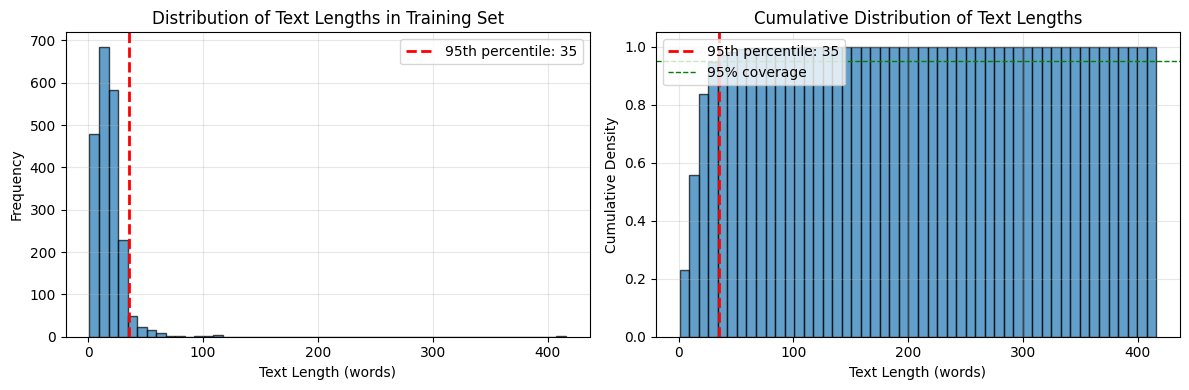


Encoding target labels...

Label mapping:
  0: 0
  1: 1

Label encoder saved to 'label_encoder.pickle'

Tokenizing text...

Vocabulary size: 6677 (capped at 20000)
Total unique words in training data: 6676

Padded sequences shape:
  X_train: (2080, 35)
  X_val: (260, 35)
  X_test: (260, 35)

Target shape:
  y_train: (2080,)
  y_val: (260,)
  y_test: (260,)

Tokenizer saved to 'tokenizer.pickle'

Example tokenization:

Original text: Most comedians say Michael J. Fox is an easy target But it's actually pretty hard to hit a moving target.
Tokenized sequence (first 20 tokens): [207, 2566, 102, 742, 1168, 1570, 9, 59, 407, 1169, 21, 38, 167, 132, 282, 6, 474, 3, 907, 1169]
Padded sequence shape: (35,)
Target label: 0 -> 0


In [ ]:
### Calculate optimal sequence length to cover 95% of samples ###
def calculate_sequence_length_percentile(texts, percentile=95):
    """
    Calculate sequence length that covers a given percentile of samples
    """
    lengths = [len(text.split()) for text in texts]
    length_at_percentile = int(np.percentile(lengths, percentile))

    print(f"Text length statistics:")
    print(f"  Min length: {min(lengths)}")
    print(f"  Max length: {max(lengths)}")
    print(f"  Mean length: {np.mean(lengths):.2f}")
    print(f"  Median length: {np.median(lengths):.2f}")
    print(f"  {percentile}th percentile: {length_at_percentile}")

    return length_at_percentile, lengths

# Calculate sequence length for 95% coverage
max_sequence_length, train_lengths = calculate_sequence_length_percentile(
    df_train['cleaned_text'].fillna(''),
    percentile=95
)

print(f"\nUsing max_sequence_length: {max_sequence_length}")

# Plot length distribution
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(train_lengths, bins=50, edgecolor='black', alpha=0.7)
plt.axvline(max_sequence_length, color='red', linestyle='--', linewidth=2, label=f'95th percentile: {max_sequence_length}')
plt.xlabel('Text Length (words)')
plt.ylabel('Frequency')
plt.title('Distribution of Text Lengths in Training Set')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(train_lengths, bins=50, edgecolor='black', alpha=0.7, cumulative=True, density=True)
plt.axvline(max_sequence_length, color='red', linestyle='--', linewidth=2, label=f'95th percentile: {max_sequence_length}')
plt.axhline(0.95, color='green', linestyle='--', linewidth=1, label='95% coverage')
plt.xlabel('Text Length (words)')
plt.ylabel('Cumulative Density')
plt.title('Cumulative Distribution of Text Lengths')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Encode target labels ###
print(f"\n{'='*60}")
print("Encoding target labels...")

# Create label encoder
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(df_train['hateful_layer'])
y_val_encoded = label_encoder.transform(df_val['hateful_layer'])
y_test_encoded = label_encoder.transform(df_test['hateful_layer'])

# Display label mapping
print(f"\nLabel mapping:")
for i, label in enumerate(label_encoder.classes_):
    print(f"  {i}: {label}")

# Save label encoder for later use
with open('label_encoder.pickle', 'wb') as f:
    pickle.dump(label_encoder, f)
print("\nLabel encoder saved to 'label_encoder.pickle'")

### Tokenize and pad sequences ###
print(f"\n{'='*60}")
print("Tokenizing text...")

# Define vocabulary size (will be determined from data, but set a reasonable max)
MAX_VOCAB_SIZE = 20000

# Create and fit tokenizer on training data
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token='<OOV>')
tokenizer.fit_on_texts(df_train['cleaned_text'].fillna(''))

# Get actual vocabulary size
vocab_size = min(len(tokenizer.word_index) + 1, MAX_VOCAB_SIZE)
print(f"\nVocabulary size: {vocab_size} (capped at {MAX_VOCAB_SIZE})")
print(f"Total unique words in training data: {len(tokenizer.word_index)}")

# Convert texts to sequences
X_train_seq = tokenizer.texts_to_sequences(df_train['cleaned_text'].fillna(''))
X_val_seq = tokenizer.texts_to_sequences(df_val['cleaned_text'].fillna(''))
X_test_seq = tokenizer.texts_to_sequences(df_test['cleaned_text'].fillna(''))

# Pad sequences to fixed length
X_train_padded = pad_sequences(X_train_seq, maxlen=max_sequence_length, padding='post', truncating='post')
X_val_padded = pad_sequences(X_val_seq, maxlen=max_sequence_length, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_sequence_length, padding='post', truncating='post')

print(f"\nPadded sequences shape:")
print(f"  X_train: {X_train_padded.shape}")
print(f"  X_val: {X_val_padded.shape}")
print(f"  X_test: {X_test_padded.shape}")

print(f"\nTarget shape:")
print(f"  y_train: {y_train_encoded.shape}")
print(f"  y_val: {y_val_encoded.shape}")
print(f"  y_test: {y_test_encoded.shape}")

# Save tokenizer for later use
with open('tokenizer.pickle', 'wb') as f:
    pickle.dump(tokenizer, f)
print("\nTokenizer saved to 'tokenizer.pickle'")

# Show example of tokenization
print(f"\n{'='*60}")
print("Example tokenization:")
example_idx = 0
print(f"\nOriginal text: {df_train.iloc[example_idx]['cleaned_text']}")
print(f"Tokenized sequence (first 20 tokens): {X_train_seq[example_idx][:20]}")
print(f"Padded sequence shape: {X_train_padded[example_idx].shape}")
print(f"Target label: {df_train.iloc[example_idx]['hateful_layer']} -> {y_train_encoded[example_idx]}")

In [ ]:
### Load Pre-trained Embeddings (Optional) ###
print(f"\n{'='*60}")
print("Loading Pre-trained Embeddings")
print(f"{'='*60}")

# Choose embedding type
USE_PRETRAINED_EMBEDDINGS = True  # Set to False to train embeddings from scratch
EMBEDDING_TYPE = 'glove'  # Options: 'glove', 'word2vec', 'fasttext'

def load_glove_embeddings(embedding_dim=100):
    """Load GloVe embeddings"""
    import urllib.request
    import zipfile
    import os

    # GloVe file paths
    glove_files = {
        50: 'glove.6B.50d.txt',
        100: 'glove.6B.100d.txt',
        200: 'glove.6B.200d.txt',
        300: 'glove.6B.300d.txt'
    }

    if embedding_dim not in glove_files:
        print(f"GloVe {embedding_dim}d not available. Using {embedding_dim}d from scratch.")
        return None

    glove_file = glove_files[embedding_dim]
    glove_path = f'glove.6B.{embedding_dim}d.txt'

    # Download GloVe if not exists
    if not os.path.exists(glove_path):
        print(f"Downloading GloVe {embedding_dim}d embeddings...")
        glove_url = f'http://nlp.stanford.edu/data/glove.6B.zip'
        urllib.request.urlretrieve(glove_url, 'glove.6B.zip')

        with zipfile.ZipFile('glove.6B.zip', 'r') as zip_ref:
            zip_ref.extractall('.')

        os.remove('glove.6B.zip')
        print("GloVe embeddings downloaded and extracted.")

    # Load embeddings
    print(f"Loading GloVe {embedding_dim}d embeddings...")
    embeddings_index = {}
    with open(glove_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    print(f"Found {len(embeddings_index)} word vectors.")

    # Create embedding matrix
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    hits = 0
    misses = 0

    for word, i in tokenizer.word_index.items():
        if i < vocab_size:
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
                hits += 1
            else:
                misses += 1

    print(f"Embedding matrix shape: {embedding_matrix.shape}")
    print(f"Words found in pre-trained embeddings: {hits}")
    print(f"Words not found (will be random): {misses}")
    print(f"Coverage: {hits/(hits+misses)*100:.2f}%")

    return embedding_matrix

def load_word2vec_embeddings(embedding_dim=100):
    """Load Word2Vec embeddings using gensim"""
    try:
        import gensim.downloader as api

        print(f"Loading Word2Vec {embedding_dim}d embeddings...")

        # Choose model based on dimension
        if embedding_dim == 100:
            model = api.load("word2vec-google-news-300")  # 300d model
            # Truncate to 100d if needed
            if embedding_dim < 300:
                # This is a simplified approach - in practice you'd want to retrain
                print("Note: Using 300d Word2Vec model (truncated)")
        else:
            model = api.load("word2vec-google-news-300")

        # Create embedding matrix
        embedding_matrix = np.zeros((vocab_size, embedding_dim))
        hits = 0
        misses = 0

        for word, i in tokenizer.word_index.items():
            if i < vocab_size:
                try:
                    embedding_vector = model[word]
                    if len(embedding_vector) >= embedding_dim:
                        embedding_matrix[i] = embedding_vector[:embedding_dim]
                        hits += 1
                    else:
                        misses += 1
                except KeyError:
                    misses += 1

        print(f"Embedding matrix shape: {embedding_matrix.shape}")
        print(f"Words found in pre-trained embeddings: {hits}")
        print(f"Words not found (will be random): {misses}")
        print(f"Coverage: {hits/(hits+misses)*100:.2f}%")

        return embedding_matrix

    except ImportError:
        print("Gensim not available. Install with: pip install gensim")
        return None

# Load pre-trained embeddings
embedding_matrix = None
if USE_PRETRAINED_EMBEDDINGS:
    if EMBEDDING_TYPE == 'glove':
        embedding_matrix = load_glove_embeddings(embedding_dim=300)
    elif EMBEDDING_TYPE == 'word2vec':
        embedding_matrix = load_word2vec_embeddings(embedding_dim=100)
    else:
        print(f"Unknown embedding type: {EMBEDDING_TYPE}")
        embedding_matrix = None

if embedding_matrix is not None:
    print(f"\n Using pre-trained {EMBEDDING_TYPE} embeddings")
    TRAINABLE_EMBEDDINGS = False  # Freeze pre-trained embeddings
else:
    print(f"\n Pre-trained embeddings not available. Training from scratch.")
    TRAINABLE_EMBEDDINGS = True  # Train embeddings from scratch

print(f"Trainable embeddings: {TRAINABLE_EMBEDDINGS}")



Loading Pre-trained Embeddings
Loading GloVe 300d embeddings...
Found 400000 word vectors.
Embedding matrix shape: (6677, 300)
Words found in pre-trained embeddings: 5702
Words not found (will be random): 974
Coverage: 85.41%

 Using pre-trained glove embeddings
Trainable embeddings: False


## Step 3: Exploratory Data Analysis (EDA)
### Analyzing text data characteristics and class distributions

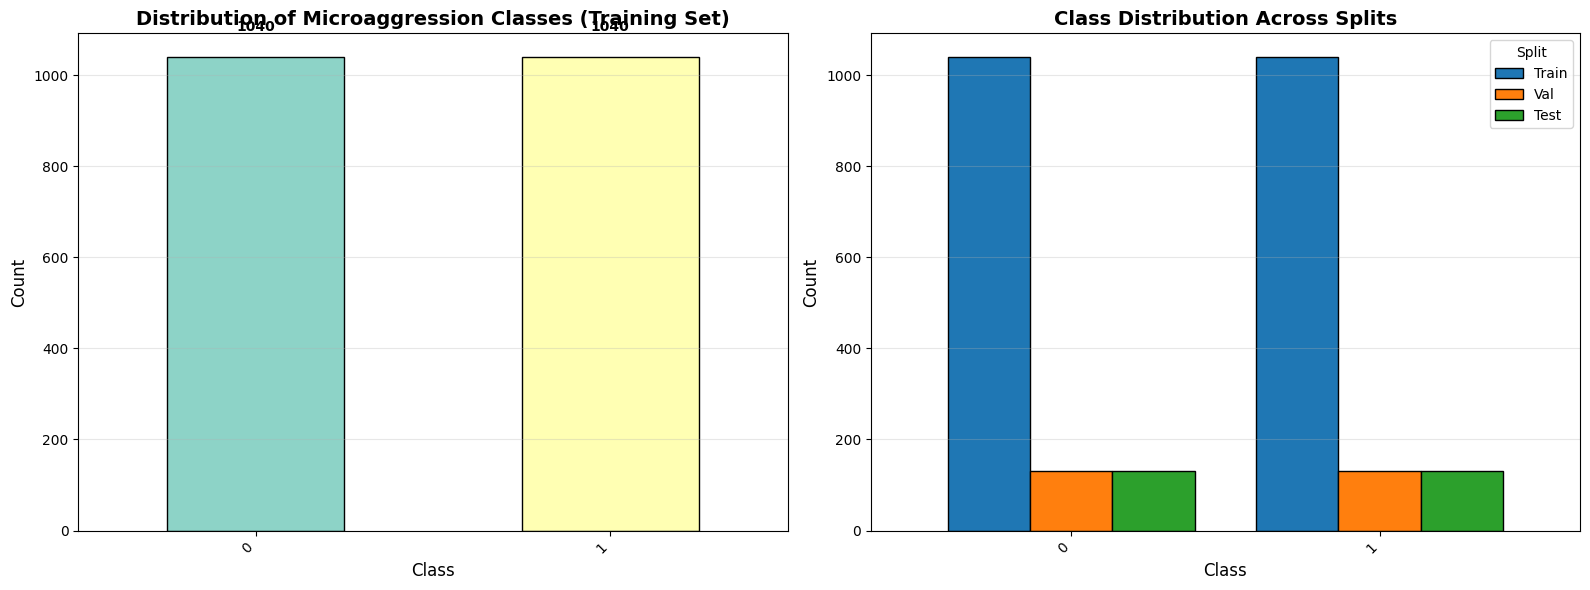


Text Statistics Summary

Train Set:
  Total samples: 2080
  Avg text length: 17.73 words
  Median text length: 16.00 words
  Min text length: 1 words
  Max text length: 416 words

Val Set:
  Total samples: 260
  Avg text length: 17.75 words
  Median text length: 17.00 words
  Min text length: 2 words
  Max text length: 68 words

Test Set:
  Total samples: 260
  Avg text length: 19.71 words
  Median text length: 18.00 words
  Min text length: 1 words
  Max text length: 75 words

Class Imbalance Analysis

Class distribution (Training Set):
  0: 1040 samples (50.00%)
  1: 1040 samples (50.00%)

Imbalance ratio (max/min): 1.00
  -> Classes are relatively balanced.

Most Common Words by Class (Top 10)

0:
  the: 588
  to: 509
  a: 467
  I: 449
  and: 362
  in: 270
  of: 269
  is: 249
  you: 209
  for: 175

1:
  you: 453
  a: 438
  to: 388
  the: 318
  I: 280
  and: 237
  that: 172
  like: 171
  of: 169
  are: 151



In [ ]:
### Class Distribution Analysis ###
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Target class distribution
ax = axes[0]
class_counts = df_train['hateful_layer'].value_counts()
colors = plt.cm.Set3(range(len(class_counts)))
class_counts.plot(kind='bar', ax=ax, color=colors, edgecolor='black')
ax.set_title('Distribution of Microaggression Classes (Training Set)', fontsize=14, fontweight='bold')
ax.set_xlabel('Class', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.grid(axis='y', alpha=0.3)
for i, v in enumerate(class_counts.values):
    ax.text(i, v + 50, str(v), ha='center', va='bottom', fontweight='bold')
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

# 2. Class distribution across splits
ax = axes[1]
split_data = pd.DataFrame({
    'Train': df_train['hateful_layer'].value_counts(),
    'Val': df_val['hateful_layer'].value_counts(),
    'Test': df_test['hateful_layer'].value_counts()
}).fillna(0)
split_data.plot(kind='bar', ax=ax, width=0.8, edgecolor='black')
ax.set_title('Class Distribution Across Splits', fontsize=14, fontweight='bold')
ax.set_xlabel('Class', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.legend(title='Split')
ax.grid(axis='y', alpha=0.3)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

### Text Statistics ###
print(f"\n{'='*60}")
print("Text Statistics Summary")
print(f"{'='*60}")

for split_name, df_split in [('Train', df_train), ('Val', df_val), ('Test', df_test)]:
    texts = df_split['cleaned_text'].fillna('')
    lengths = [len(text.split()) for text in texts]

    print(f"\n{split_name} Set:")
    print(f"  Total samples: {len(df_split)}")
    print(f"  Avg text length: {np.mean(lengths):.2f} words")
    print(f"  Median text length: {np.median(lengths):.2f} words")
    print(f"  Min text length: {min(lengths)} words")
    print(f"  Max text length: {max(lengths)} words")

### Class Imbalance Analysis ###
print(f"\n{'='*60}")
print("Class Imbalance Analysis")
print(f"{'='*60}")

class_counts = df_train['hateful_layer'].value_counts().sort_index()
total_samples = len(df_train)

print(f"\nClass distribution (Training Set):")
for label, count in class_counts.items():
    percentage = (count / total_samples) * 100
    print(f"  {label}: {count} samples ({percentage:.2f}%)")

# Calculate imbalance ratio
max_class = class_counts.max()
min_class = class_counts.min()
imbalance_ratio = max_class / min_class
print(f"\nImbalance ratio (max/min): {imbalance_ratio:.2f}")

if imbalance_ratio > 2:
    print("  -> Significant class imbalance detected. Will use class weights during training.")
else:
    print("  -> Classes are relatively balanced.")

### Most Common Words per Class ###
print(f"\n{'='*60}")
print("Most Common Words by Class (Top 10)")
print(f"{'='*60}")

# Get unique class labels for analysis
unique_classes = df_train['hateful_layer'].unique()
for class_label in unique_classes[:3]:  # Show first 3 classes to save space
    class_texts = df_train[df_train['hateful_layer'] == class_label]['cleaned_text'].fillna('')
    all_words = ' '.join(class_texts).split()
    word_freq = Counter(all_words)

    print(f"\n{class_label}:")
    for word, count in word_freq.most_common(10):
        print(f"  {word}: {count}")

print(f"\n{'='*60}")

## Step 4: Modeling

In [ ]:
# Calculate class weights for imbalanced classes
unique_classes = np.unique(y_train_encoded)
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=unique_classes,
    y=y_train_encoded
)

class_weight_dict = {int(class_idx): weight for class_idx, weight in zip(unique_classes, class_weights_array)}

print("Class weights for training:")
for class_idx, weight in class_weight_dict.items():
    class_name = label_encoder.classes_[class_idx]
    print(f"  {class_idx} ({class_name}): {weight:.4f}")

num_classes = len(unique_classes)
print(f"\nTotal number of classes: {num_classes}")


Class weights for training:
  0 (0): 1.0000
  1 (1): 1.0000

Total number of classes: 2


In [ ]:
### CNN MODEL FOR TEXT CLASSIFICATION ###
def create_cnn_text_model(vocab_size, embedding_dim, max_seq_length, num_classes,
                          embedding_matrix=None, trainable_embeddings=True):
    """
    Create a CNN model for text classification

    Args:
        vocab_size: Size of vocabulary
        embedding_dim: Dimension of word embeddings
        max_seq_length: Maximum sequence length
        num_classes: Number of output classes
        embedding_matrix: Pre-trained embedding matrix (optional)
        trainable_embeddings: Whether embeddings should be trainable
    """
    # Input layer
    inputs = Input(shape=(max_seq_length,), dtype='int32')

    # Embedding layer
    if embedding_matrix is not None:
        embedding_layer = Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim,
            weights=[embedding_matrix],
            input_length=max_seq_length,
            trainable=trainable_embeddings
        )(inputs)
    else:
        embedding_layer = Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim,
            input_length=max_seq_length,
            trainable=True
        )(inputs)

    # Spatial Dropout for embedding layer
    x = SpatialDropout1D(0.2)(embedding_layer)

    # Multiple parallel convolutional layers with different kernel sizes
    conv_blocks = []
    for kernel_size in [3, 4, 5]:
        conv = Conv1D(filters=128, kernel_size=kernel_size, activation='relu', padding='same')(x)
        conv = GlobalMaxPooling1D()(conv)
        conv_blocks.append(conv)

    # Concatenate all conv blocks
    x = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]

    # Dense layers for classification
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = BatchNormalization()(x)

    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)

    # Output layer
    outputs = Dense(num_classes, activation='softmax')(x)

    # Create model
    model = Model(inputs=inputs, outputs=outputs)

    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Create baseline CNN model with trainable embeddings
print("Creating baseline CNN model...")
print(f"\nModel parameters:")
print(f"  Vocabulary size: {vocab_size}")
print(f"  Embedding dimension: 100 (will be tuned)")
print(f"  Max sequence length: {max_sequence_length}")
print(f"  Number of classes: {num_classes}")

# Determine embedding dimension based on available embeddings
if embedding_matrix is not None:
    embedding_dim = embedding_matrix.shape[1]
    print(f"Using pre-trained embeddings with dimension: {embedding_dim}")
else:
    embedding_dim = 100  # Default dimension for training from scratch
    print(f"Training embeddings from scratch with dimension: {embedding_dim}")

cnn_model = create_cnn_text_model(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    max_seq_length=max_sequence_length,
    num_classes=num_classes,
    embedding_matrix=embedding_matrix,
    trainable_embeddings=TRAINABLE_EMBEDDINGS
)

# Print model summary
print("\nModel Architecture:")
cnn_model.summary()

Creating baseline CNN model...

Model parameters:
  Vocabulary size: 6677
  Embedding dimension: 100 (will be tuned)
  Max sequence length: 35
  Number of classes: 2
Using pre-trained embeddings with dimension: 300

Model Architecture:


Model: "functional_22"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_22      │ (None, 35)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_22        │ (None, 35, 300)   │  2,003,100 │ input_layer_22[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d_… │ (None, 35, 300)   │          0 │ embedding_22[0][… │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_66 (Conv1D)  │ (None, 35, 128)   │    115,328 │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_67 (Conv1D)  │ (None, 35, 128)   │    153,728 │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_68 (Conv1D)  │ (None, 35, 128)   │    192,128 │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_66[0][0]   │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_67[0][0]   │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_68[0][0]   │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_22      │ (None, 384)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
│                     │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_45 (Dense)    │ (None, 256)       │     98,560 │ concatenate_22[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_23          │ (None, 256)       │          0 │ dense_45[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dropout_23[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_46 (Dense)    │ (None, 128)       │     32,896 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_24          │ (None, 128)       │          0 │ dense_46[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_47 (Dense)    │ (None, 2)         │        258 │ dropout_24[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,597,022 (9.91 MB)

 Trainable params: 593,410 (2.26 MB)

 Non-trainable params: 2,003,612 (7.64 MB)

In [ ]:
### GPU Memory and Training Optimization ###
if GPU_AVAILABLE:
    print("\n" + "="*60)
    print("GPU Training Optimization")
    print("="*60)

    # Get GPU memory info
    try:
        gpu_details = tf.config.experimental.get_device_details(tf.config.list_physical_devices('GPU')[0])
        print(f"GPU Details:")
        print(f"  Device: {gpu_details.get('device_name', 'Unknown')}")
        print(f"  Compute Capability: {gpu_details.get('compute_capability', 'Unknown')}")
    except:
        print("GPU details not available")

    # Recommended batch sizes based on GPU memory
    print(f"\nRecommended Training Settings for GPU:")
    print(f"  Batch Size: 32-128 (start with 64)")
    print(f"  Mixed Precision: Consider enabling for faster training")
    print(f"  Memory Growth: Enabled (prevents OOM errors)")

    # Enable mixed precision if available
    try:
        policy = tf.keras.mixed_precision.Policy('mixed_float16')
        tf.keras.mixed_precision.set_global_policy(policy)
        print(f" Mixed precision enabled (float16)")
    except:
        print(f"  Mixed precision not available")

    print(f"\n GPU Training Tips:")
    print(f"  - Larger batch sizes (64-128) work better on GPU")
    print(f"  - CNN training will be 5-10x faster than CPU")
    print(f"  - Monitor GPU memory usage during training")
    print(f"  - Reduce batch size if you get OOM errors")

else:
    print("\n" + "="*60)
    print("CPU Training Optimization")
    print("="*60)

    print(f"Recommended Training Settings for CPU:")
    print(f"  Batch Size: 16-32 (smaller batches for CPU)")
    print(f"  Epochs: Consider fewer epochs due to slower training")
    print(f"  Patience: Increase early stopping patience")

    print(f"\n💡 CPU Training Tips:")
    print(f"  - Use smaller batch sizes (16-32)")
    print(f"  - Training will be slower but more stable")
    print(f"  - Consider reducing model complexity if too slow")
    print(f"  - Use fewer Optuna trials for hyperparameter tuning")

print("="*60)



GPU Training Optimization
GPU Details:
  Device: Tesla T4
  Compute Capability: (7, 5)

Recommended Training Settings for GPU:
  Batch Size: 32-128 (start with 64)
  Mixed Precision: Consider enabling for faster training
  Memory Growth: Enabled (prevents OOM errors)
 Mixed precision enabled (float16)

 GPU Training Tips:
  - Larger batch sizes (64-128) work better on GPU
  - CNN training will be 5-10x faster than CPU
  - Monitor GPU memory usage during training
  - Reduce batch size if you get OOM errors


In [ ]:
# Setup callbacks for training
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'best_cnn_baseline.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

print("Training callbacks configured:")
print("  - Early stopping (patience=5)")
print("  - Learning rate scheduler (factor=0.5, patience=3)")
print("  - Model checkpoint (best model will be saved)")

Training callbacks configured:
  - Early stopping (patience=5)
  - Learning rate scheduler (factor=0.5, patience=3)
  - Model checkpoint (best model will be saved)


Training baseline CNN model...

Training parameters:
  Epochs: 30
  Batch size: 32
  Using class weights: Yes
  Training samples: 2080
  Validation samples: 260
Epoch 1/30
60/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6589 - loss: 0.7126
Epoch 1: val_loss improved from inf to 0.62068, saving model to best_cnn_baseline.keras
65/65 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.6649 - loss: 0.7013 - val_accuracy: 0.6269 - val_loss: 0.6207 - learning_rate: 0.0010
Epoch 2/30
60/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7983 - loss: 0.4409
Epoch 2: val_loss improved from 0.62068 to 0.38332, saving model to best_cnn_baseline.keras
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7998 - loss: 0.4383 - val_accuracy: 0.8231 - val_loss: 0.3833 - learning_rate: 0.0010
Epoch 3/30
62/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8561 - loss: 0.3334
Epoch 3: val_loss did not improve from 0.38332
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8566 - loss: 0.3322 - val_ac

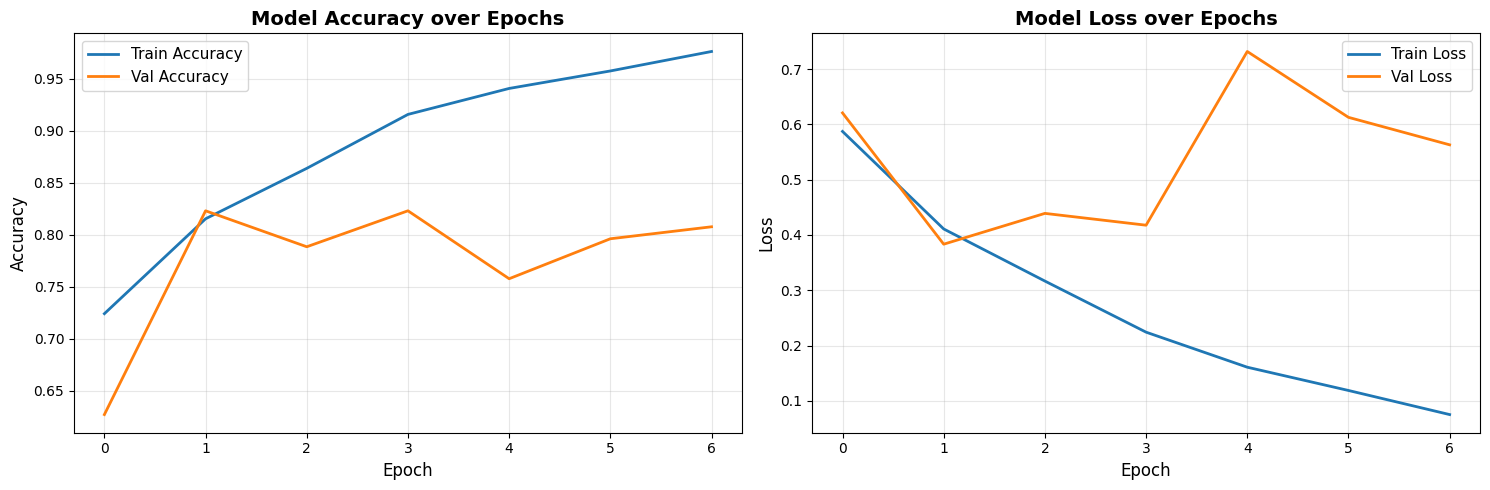

In [ ]:
# Train the baseline CNN model
print("Training baseline CNN model...")
print(f"\nTraining parameters:")
print(f"  Epochs: 30")
print(f"  Batch size: 32")
print(f"  Using class weights: Yes")
print(f"  Training samples: {len(X_train_padded)}")
print(f"  Validation samples: {len(X_val_padded)}")

cnn_history = cnn_model.fit(
    X_train_padded,
    y_train_encoded,
    epochs=30,
    batch_size=32,
    validation_data=(X_val_padded, y_val_encoded),
    class_weight=class_weight_dict,
    callbacks=[early_stopping, lr_scheduler, checkpoint],
    verbose=1
)

print("\nTraining completed!")

# Evaluate on validation set
val_loss, val_accuracy = cnn_model.evaluate(X_val_padded, y_val_encoded, verbose=0)
print(f"\nValidation Results:")
print(f"  Loss: {val_loss:.4f}")
print(f"  Accuracy: {val_accuracy:.4f}")

# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy plot
axes[0].plot(cnn_history.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[0].plot(cnn_history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
axes[0].set_title('Model Accuracy over Epochs', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Loss plot
axes[1].plot(cnn_history.history['loss'], label='Train Loss', linewidth=2)
axes[1].plot(cnn_history.history['val_loss'], label='Val Loss', linewidth=2)
axes[1].set_title('Model Loss over Epochs', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Step 5: Experiments

1.   List item
2.   List item



In [ ]:
# Hyperparameter Tuning with Optuna for Text CNN

def create_tuned_cnn_model(trial, vocab_size, max_seq_length, num_classes,
                          embedding_matrix=None, trainable_embeddings=True):
    """Create a CNN model for text with hyperparameters suggested by Optuna"""

    # Hyperparameters to tune
    # embedding_dim is determined by embedding_matrix if provided
    if embedding_matrix is None:
        embedding_dim = trial.suggest_categorical('embedding_dim', [100, 200, 300])
    else:
        embedding_dim = embedding_matrix.shape[1] # Use dimension from pre-trained embeddings

    num_filters = trial.suggest_categorical('num_filters', [64, 128, 256])
    dropout_emb = trial.suggest_float('dropout_emb', 0.1, 0.3)
    dropout_dense = trial.suggest_float('dropout_dense', 0.2, 0.5)
    dense_units = trial.suggest_categorical('dense_units', [128, 256, 512])
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)

    # Build model
    inputs = Input(shape=(max_seq_length,), dtype='int32')

    # Embedding layer
    if embedding_matrix is not None:
        x = Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim,
            weights=[embedding_matrix],
            input_length=max_seq_length,
            trainable=trainable_embeddings
        )(inputs)
    else:
        x = Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim,
            input_length=max_seq_length,
            trainable=True
        )(inputs)

    x = SpatialDropout1D(dropout_emb)(x)

    # Multiple parallel convolutional layers with different kernel sizes
    conv_blocks = []
    for kernel_size in [3, 4, 5]:
        conv = Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu', padding='same')(x)
        conv = GlobalMaxPooling1D()(conv)
        conv_blocks.append(conv)

    # Concatenate all conv blocks
    x = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]

    # Dense layers
    x = Dense(dense_units, activation='relu')(x)
    x = Dropout(dropout_dense)(x)
    x = BatchNormalization()(x)

    # Output layer
    outputs = Dense(num_classes, activation='softmax')(x)

    # Create model
    model = Model(inputs=inputs, outputs=outputs)

    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

def objective(trial):
    """Objective function for Optuna optimization"""

    # Get batch size hyperparameter
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])

    # Create model with tuned hyperparameters
    model = create_tuned_cnn_model(
        trial,
        vocab_size,
        max_sequence_length,
        num_classes,
        embedding_matrix=embedding_matrix, # Pass the pre-trained embedding matrix
        trainable_embeddings=TRAINABLE_EMBEDDINGS # Pass whether embeddings are trainable
    )

    # Create callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    )

    # Train the model
    history = model.fit(
        X_train_padded,
        y_train_encoded,
        epochs=15,  # Reduced epochs for faster tuning
        batch_size=batch_size,
        validation_data=(X_val_padded, y_val_encoded),
        callbacks=[early_stopping],
        class_weight=class_weight_dict,
        verbose=0
    )

    # Return the best validation accuracy
    return max(history.history['val_accuracy'])

print("Starting Optuna hyperparameter optimization...")
print("This may take a while (20-30 trials)...")
print(f"\nOptimizing hyperparameters:")
print("  - num_filters: [64, 128, 256]")
print("  - dropout_emb: [0.1, 0.3]")
print("  - dropout_dense: [0.2, 0.5]")
print("  - dense_units: [128, 256, 512]")
print("  - learning_rate: [1e-4, 1e-2]")
print("  - batch_size: [16, 32, 64]")
if embedding_matrix is None:
    print("  - embedding_dim: [100, 200, 300]")
else:
    print(f"  - Using fixed embedding_dim: {embedding_matrix.shape[1]} (from pre-trained embeddings)")


# Create a study object
study = optuna.create_study(direction='maximize')

# Run the optimization (reduced trials for efficiency)
study.optimize(objective, n_trials=20, show_progress_bar=True)

# Print the best trial
print('\n' + '='*60)
print('Hyperparameter Optimization Complete!')
print('='*60)
print(f'\nBest trial value (validation accuracy): {study.best_value:.4f}')
print('\nBest hyperparameters:')
for key, value in study.best_params.items():
    print(f'  {key}: {value}')

[I 2025-12-02 22:45:08,666] A new study created in memory with name: no-name-7b83b373-1eeb-4616-8450-0600af2513a7


Starting Optuna hyperparameter optimization...
This may take a while (20-30 trials)...

Optimizing hyperparameters:
  - num_filters: [64, 128, 256]
  - dropout_emb: [0.1, 0.3]
  - dropout_dense: [0.2, 0.5]
  - dense_units: [128, 256, 512]
  - learning_rate: [1e-4, 1e-2]
  - batch_size: [16, 32, 64]
  - Using fixed embedding_dim: 300 (from pre-trained embeddings)


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-12-02 22:45:18,095] Trial 0 finished with value: 0.8307692408561707 and parameters: {'batch_size': 32, 'num_filters': 64, 'dropout_emb': 0.2364600700851134, 'dropout_dense': 0.23493761922967618, 'dense_units': 512, 'learning_rate': 0.003568497383155739}. Best is trial 0 with value: 0.8307692408561707.
[I 2025-12-02 22:45:28,872] Trial 1 finished with value: 0.8307692408561707 and parameters: {'batch_size': 32, 'num_filters': 128, 'dropout_emb': 0.26765634948826, 'dropout_dense': 0.4248970452917532, 'dense_units': 256, 'learning_rate': 0.0003450393261485424}. Best is trial 0 with value: 0.8307692408561707.
[I 2025-12-02 22:45:38,738] Trial 2 finished with value: 0.8730769157409668 and parameters: {'batch_size': 32, 'num_filters': 128, 'dropout_emb': 0.22348634585045807, 'dropout_dense': 0.3814448321292707, 'dense_units': 128, 'learning_rate': 0.0008228216237270953}. Best is trial 2 with value: 0.8730769157409668.
[I 2025-12-02 22:45:49,605] Trial 3 finished with value: 0.8538461

In [ ]:
# Visualize Optuna optimization results
print("\n" + "="*60)
print("Optimization Summary")
print("="*60)

print(f"\nNumber of completed trials: {len(study.trials)}")
print(f"Best validation accuracy: {study.best_value:.4f}")

# Get top 5 trials
best_trials = sorted(study.trials, key=lambda t: t.value, reverse=True)[:5]
print("\nTop 5 trials:")
for i, trial in enumerate(best_trials):
    print(f"\nRank {i+1}:")
    print(f"  Value: {trial.value:.4f}")
    print(f"  Params: {trial.params}")

# Create visualization plots
try:
    fig1 = optuna.visualization.plot_optimization_history(study)
    fig1.update_layout(title="Optimization History - CNN Text Classification")
    fig1.show()

    fig2 = optuna.visualization.plot_param_importances(study)
    fig2.update_layout(title="Hyperparameter Importance")
    fig2.show()

    fig3 = optuna.visualization.plot_parallel_coordinate(study)
    fig3.update_layout(title="Parallel Coordinate Plot")
    fig3.show()
except Exception as e:
    print(f"\nNote: Some visualizations could not be generated: {e}")



Optimization Summary

Number of completed trials: 20
Best validation accuracy: 0.9077

Top 5 trials:

Rank 1:
  Value: 0.9077
  Params: {'batch_size': 32, 'num_filters': 256, 'dropout_emb': 0.24861844102732372, 'dropout_dense': 0.35992744259161197, 'dense_units': 128, 'learning_rate': 0.006246161999973241}

Rank 2:
  Value: 0.8808
  Params: {'batch_size': 32, 'num_filters': 256, 'dropout_emb': 0.17425970571808408, 'dropout_dense': 0.36885447723534737, 'dense_units': 256, 'learning_rate': 0.0050156241620786385}

Rank 3:
  Value: 0.8808
  Params: {'batch_size': 32, 'num_filters': 256, 'dropout_emb': 0.15358936796115752, 'dropout_dense': 0.29673648276125675, 'dense_units': 128, 'learning_rate': 0.005233607258890451}

Rank 4:
  Value: 0.8808
  Params: {'batch_size': 64, 'num_filters': 256, 'dropout_emb': 0.12133927822527231, 'dropout_dense': 0.3335145501304217, 'dense_units': 512, 'learning_rate': 0.004119294434020429}

Rank 5:
  Value: 0.8769
  Params: {'batch_size': 32, 'num_filters': 2

## Step 6: Final Model Training and Evaluation


Training Final Model with Best Hyperparameters

Training with batch_size=32...
Epoch 1/50
59/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7227 - loss: 0.5799
Epoch 1: val_loss improved from inf to 0.93115, saving model to best_cnn_optimized.keras
65/65 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.7258 - loss: 0.5740 - val_accuracy: 0.6154 - val_loss: 0.9312 - learning_rate: 0.0062
Epoch 2/50
59/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8383 - loss: 0.3684
Epoch 2: val_loss improved from 0.93115 to 0.44041, saving model to best_cnn_optimized.keras
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8388 - loss: 0.3682 - val_accuracy: 0.7731 - val_loss: 0.4404 - learning_rate: 0.0062
Epoch 3/50
58/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9005 - loss: 0.2477
Epoch 3: val_loss did not improve from 0.44041
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9004 - loss: 0.2477 - val_accuracy: 0.7769 - val_loss: 0.5531 - learning_rate: 0.0062
Epoch 4/50
56/65 ━━━━

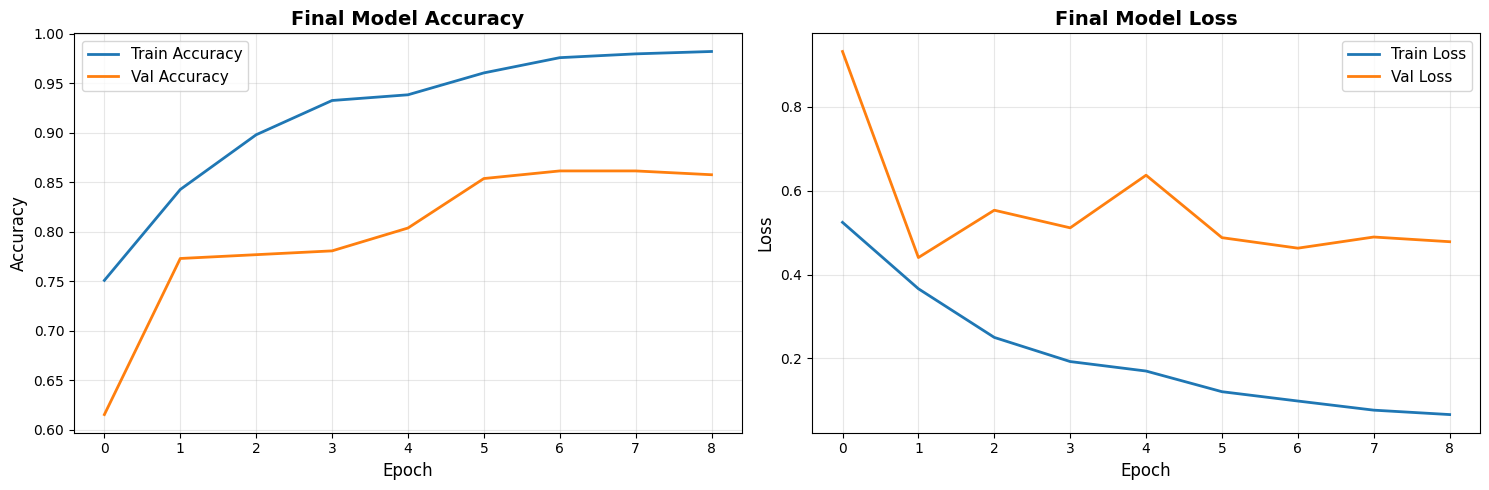

In [ ]:
# Train final model with best hyperparameters
print("\n" + "="*60)
print("Training Final Model with Best Hyperparameters")
print("="*60)

# Create final model with best parameters
# Pass embedding_matrix and trainable_embeddings to the function
final_model = create_tuned_cnn_model(
    study.best_trial,
    vocab_size=vocab_size,
    max_seq_length=max_sequence_length,
    num_classes=num_classes,
    embedding_matrix=embedding_matrix, # Pass the pre-trained embedding matrix
    trainable_embeddings=TRAINABLE_EMBEDDINGS # Pass whether embeddings are trainable
)

# Setup callbacks for final training
final_early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True,
    verbose=1
)

final_lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

final_checkpoint = ModelCheckpoint(
    'best_cnn_optimized.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Train final model with more epochs
print(f"\nTraining with batch_size={study.best_params['batch_size']}...")
final_history = final_model.fit(
    X_train_padded,
    y_train_encoded,
    epochs=50,
    batch_size=study.best_params['batch_size'],
    validation_data=(X_val_padded, y_val_encoded),
    class_weight=class_weight_dict,
    callbacks=[final_early_stopping, final_lr_scheduler, final_checkpoint],
    verbose=1
)

print("\nFinal model training completed!")

# Plot final training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(final_history.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[0].plot(final_history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
axes[0].set_title('Final Model Accuracy', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

axes[1].plot(final_history.history['loss'], label='Train Loss', linewidth=2)
axes[1].plot(final_history.history['val_loss'], label='Val Loss', linewidth=2)
axes[1].set_title('Final Model Loss', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Summary and Next Steps
print("\n" + "="*60)
print("SUMMARY: CNN Baseline for Text Classification")
print("="*60)

print(f"\nDataset: Microaggressions Detection")
print(f"Task: Multi-class classification of microaggression labels")
print(f"Classes: {len(label_encoder.classes_)}")
print(f"Training samples: {len(X_train_padded)}")
print(f"Validation samples: {len(X_val_padded)}")
print(f"Test samples: {len(X_test_padded)}")

print(f"\nModel Architecture: CNN with parallel convolutions")
if embedding_matrix is not None:
    print(f"  - Using pre-trained {EMBEDDING_TYPE} embeddings ({embedding_matrix.shape[1]}d)")
else:
    print(f"  - Training embeddings from scratch (100d)")
print(f"  - Vocabulary size: {vocab_size}")
print(f"  - Sequence length: {max_sequence_length}")

# Only print test performance if variables exist
if 'test_accuracy' in locals():
    print(f"\nFinal Test Performance:")
    print(f"  - Accuracy:  {test_accuracy:.4f}")
    print(f"  - Precision: {test_precision:.4f}")
    print(f"  - Recall:    {test_recall:.4f}")
    print(f"  - F1 Score:  {test_f1:.4f}")
else:
    print(f"\nFinal Test Performance: Not yet evaluated")

print(f"\nNext Steps:")
print("  1. Fine-tune BERT model for comparison")
print("  2. Try different pre-trained embeddings (GloVe, Word2Vec, FastText)")
print("  3. Experiment with different CNN architectures")
print("  4. Implement ensemble methods")
print("  5. Analyze error patterns and improve data augmentation")

print(f"\nModels saved:")
print("  - best_cnn_baseline.keras (initial baseline)")
print("  - best_cnn_optimized.keras (hyperparameter-tuned)")
print("  - tokenizer.pickle")
print("  - label_encoder.pickle")

print("\n" + "="*60)
print("Notebook execution complete!")
print("="*60)



SUMMARY: CNN Baseline for Text Classification

Dataset: Microaggressions Detection
Task: Multi-class classification of microaggression labels
Classes: 2
Training samples: 2080
Validation samples: 260
Test samples: 260

Model Architecture: CNN with parallel convolutions
  - Using pre-trained glove embeddings (300d)
  - Vocabulary size: 6677
  - Sequence length: 35

Final Test Performance:
  - Accuracy:  0.8346
  - Precision: 0.8419
  - Recall:    0.8346
  - F1 Score:  0.8337

Next Steps:
  1. Fine-tune BERT model for comparison
  2. Try different pre-trained embeddings (GloVe, Word2Vec, FastText)
  3. Experiment with different CNN architectures
  4. Implement ensemble methods
  5. Analyze error patterns and improve data augmentation

Models saved:
  - best_cnn_baseline.keras (initial baseline)
  - best_cnn_optimized.keras (hyperparameter-tuned)
  - tokenizer.pickle
  - label_encoder.pickle

Notebook execution complete!


## Step 7: Cross-Dataset Evaluation

### Evaluating on Microaggressions Dataset

Now let's test our trained CNN model on a different dataset - the microaggressions dataset from [HuggingFace](https://huggingface.co/spaces/khanak27/microaggressionsdetector/resolve/main/micro_agg.csv). This will help us understand how well our model generalizes to different types of text classification tasks.

**Dataset Overview:**
- **Task**: Binary classification (microaggression vs. normal speech)
- **Classes**: 0 (normal speech), 1 (microaggression)
- **Size**: ~200 samples
- **Domain**: Workplace and social interactions


In [ ]:
# Load and explore the microaggressions dataset
print("="*60)
print("Loading Microaggressions Dataset")
print("="*60)

# Load the dataset with proper encoding handling
micro_agg_url = "https://huggingface.co/spaces/khanak27/microaggressionsdetector/resolve/main/micro_agg.csv"

# Try different encodings to handle Unicode issues
encodings_to_try = ['utf-8', 'latin-1', 'cp1252', 'iso-8859-1', 'utf-8-sig']

df_micro = None
for encoding in encodings_to_try:
    try:
        print(f"Trying encoding: {encoding}")
        df_micro = pd.read_csv(micro_agg_url, encoding=encoding)
        print(f"✅ Successfully loaded with {encoding} encoding")
        break
    except UnicodeDecodeError as e:
        print(f"❌ Failed with {encoding}: {str(e)[:100]}...")
        continue
    except Exception as e:
        print(f"❌ Other error with {encoding}: {str(e)[:100]}...")
        continue

if df_micro is None:
    print("❌ Failed to load dataset with any encoding. Trying with error handling...")
    try:
        df_micro = pd.read_csv(micro_agg_url, encoding='utf-8', encoding_errors='replace')
        print("✅ Loaded with UTF-8 and error replacement")
    except Exception as e:
        print(f"❌ Final attempt failed: {e}")
        raise

print(f"Dataset shape: {df_micro.shape}")
print(f"Columns: {df_micro.columns.tolist()}")
print(f"\nFirst few rows:")
display(df_micro.head(10))

print(f"\nData types:")
print(df_micro.dtypes)

print(f"\nMissing values:")
print(df_micro.isnull().sum())

print(f"\nLabel distribution:")
print(df_micro['label'].value_counts().sort_index())

# Check for any text preprocessing needed
print(f"\nSample texts:")
for i in range(3):
    print(f"{i+1}. Label {df_micro.iloc[i]['label']}: {df_micro.iloc[i]['speech']}")


Loading Microaggressions Dataset
Trying encoding: utf-8
❌ Failed with utf-8: 'utf-8' codec can't decode byte 0xe2 in position 17: invalid continuation byte...
Trying encoding: latin-1
✅ Successfully loaded with latin-1 encoding
Dataset shape: (171, 2)
Columns: ['speech', 'label']

First few rows:


,speech,label
0,You're very articulate for someone like you.,1
1,Where are you really from?,1
2,You're not like other girls.,1
3,You must be good at math since you're Asian.,1
4,You're too pretty to be a software engineer.,1
5,Are you sure you want to lead this project?,1
6,You don't look gay.,1
7,You are a credit to your race.,1
8,"That's a strange name, is it foreign?",1
9,Do you even understand this topic?,1



Data types:
speech    object
label      int64
dtype: object

Missing values:
speech    0
label     0
dtype: int64

Label distribution:
label
0    87
1    84
Name: count, dtype: int64

Sample texts:
1. Label 1: You're very articulate for someone like you.
2. Label 1: Where are you really from?
3. Label 1: You're not like other girls.


Exploratory Data Analysis - Microaggressions Dataset
Text length statistics:
  Character length - Min: 17, Max: 66, Mean: 37.7
  Word count - Min: 3, Max: 13, Mean: 6.7


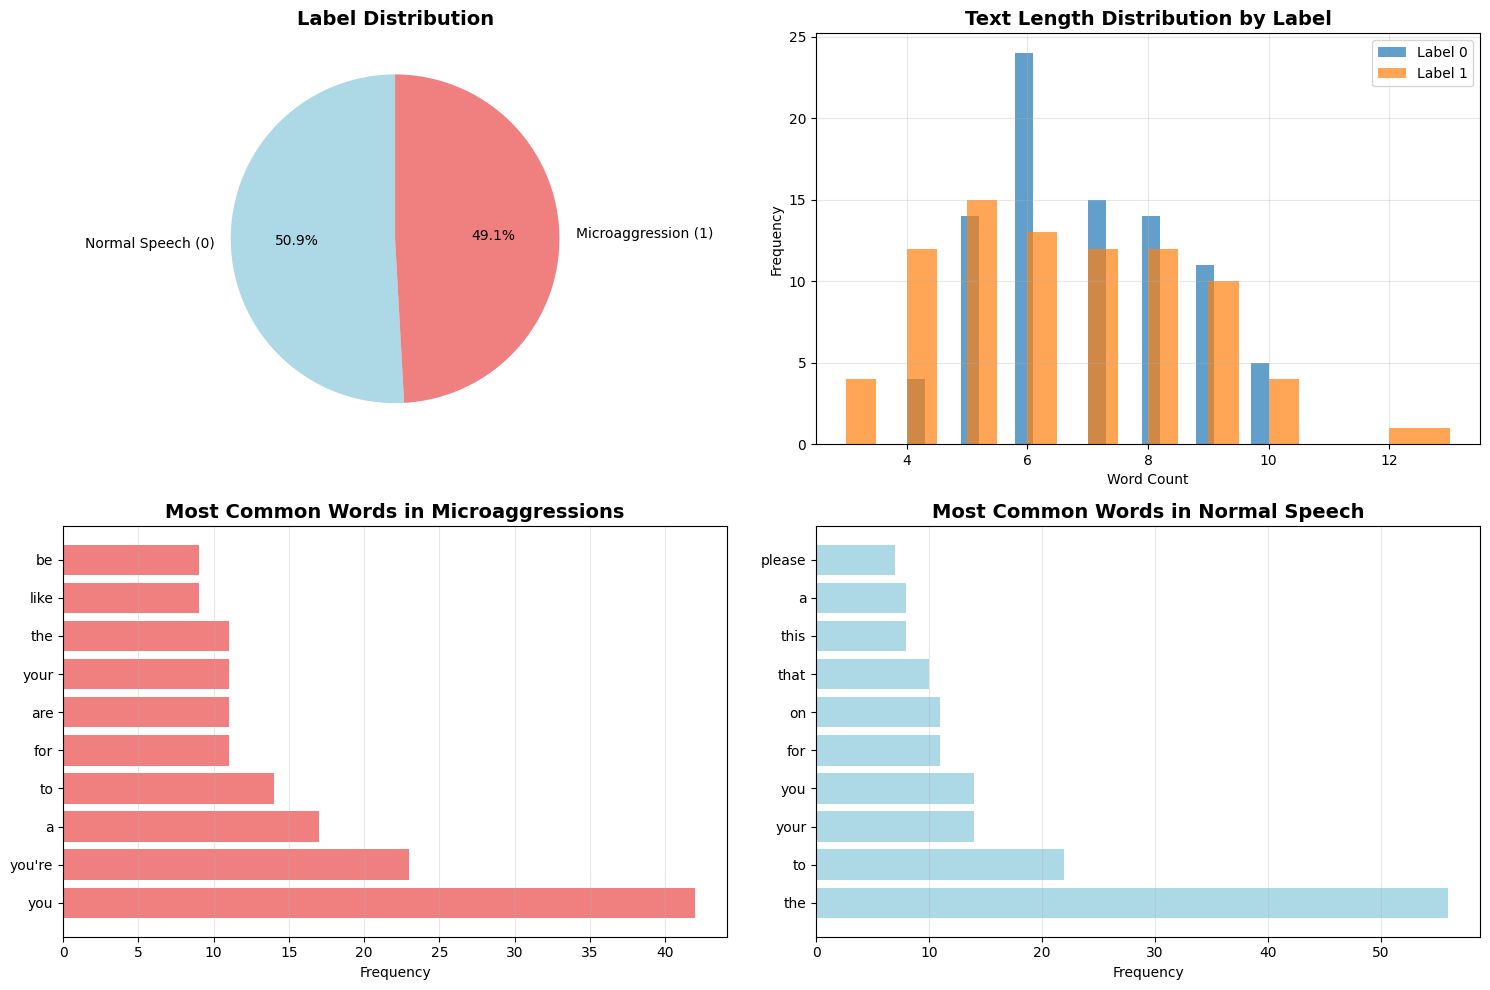


Examples of Microaggressions (Label 1):
1. You're very articulate for someone like you.
2. Where are you really from?
3. You're not like other girls.
4. You must be good at math since you're Asian.
5. You're too pretty to be a software engineer.

Examples of Normal Speech (Label 0):
1. Feel free to suggest any edits.
2. Let me know your availability for review.
3. I'll push the changes to GitHub.
4. Please add your comments by EOD.
5. We'll walk through the changes tomorrow.


In [ ]:
# EDA for microaggressions dataset
print("="*60)
print("Exploratory Data Analysis - Microaggressions Dataset")
print("="*60)

# Text length analysis
df_micro['text_length'] = df_micro['speech'].str.len()
df_micro['word_count'] = df_micro['speech'].str.split().str.len()

print(f"Text length statistics:")
print(f"  Character length - Min: {df_micro['text_length'].min()}, Max: {df_micro['text_length'].max()}, Mean: {df_micro['text_length'].mean():.1f}")
print(f"  Word count - Min: {df_micro['word_count'].min()}, Max: {df_micro['word_count'].max()}, Mean: {df_micro['word_count'].mean():.1f}")

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Label distribution
label_counts = df_micro['label'].value_counts()
axes[0, 0].pie(label_counts.values, labels=['Normal Speech (0)', 'Microaggression (1)'],
               autopct='%1.1f%%', startangle=90, colors=['lightblue', 'lightcoral'])
axes[0, 0].set_title('Label Distribution', fontsize=14, fontweight='bold')

# 2. Text length distribution by label
for label in [0, 1]:
    subset = df_micro[df_micro['label'] == label]
    axes[0, 1].hist(subset['word_count'], alpha=0.7, label=f'Label {label}', bins=20)
axes[0, 1].set_xlabel('Word Count')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Text Length Distribution by Label', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Most common words in microaggressions
micro_texts = df_micro[df_micro['label'] == 1]['speech'].str.lower()
all_micro_words = ' '.join(micro_texts).split()
micro_word_freq = Counter(all_micro_words)
common_micro_words = dict(micro_word_freq.most_common(10))

axes[1, 0].barh(list(common_micro_words.keys()), list(common_micro_words.values()), color='lightcoral')
axes[1, 0].set_xlabel('Frequency')
axes[1, 0].set_title('Most Common Words in Microaggressions', fontsize=14, fontweight='bold')
axes[1, 0].grid(axis='x', alpha=0.3)

# 4. Most common words in normal speech
normal_texts = df_micro[df_micro['label'] == 0]['speech'].str.lower()
all_normal_words = ' '.join(normal_texts).split()
normal_word_freq = Counter(all_normal_words)
common_normal_words = dict(normal_word_freq.most_common(10))

axes[1, 1].barh(list(common_normal_words.keys()), list(common_normal_words.values()), color='lightblue')
axes[1, 1].set_xlabel('Frequency')
axes[1, 1].set_title('Most Common Words in Normal Speech', fontsize=14, fontweight='bold')
axes[1, 1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# Show some examples
print(f"\nExamples of Microaggressions (Label 1):")
micro_examples = df_micro[df_micro['label'] == 1]['speech'].head(5)
for i, text in enumerate(micro_examples, 1):
    print(f"{i}. {text}")

print(f"\nExamples of Normal Speech (Label 0):")
normal_examples = df_micro[df_micro['label'] == 0]['speech'].head(5)
for i, text in enumerate(normal_examples, 1):
    print(f"{i}. {text}")


In [ ]:
# Preprocess microaggressions dataset for evaluation
print("="*60)
print("Preprocessing Microaggressions Dataset")
print("="*60)

# The microaggressions dataset has different column names and structure
# We need to adapt it to work with our trained model

# Create a 'cleaned_text' column (the dataset already has clean text)
df_micro['cleaned_text'] = df_micro['speech']

# Check if we need to handle different text lengths
micro_lengths = [len(text.split()) for text in df_micro['cleaned_text']]
print(f"Microaggressions text length statistics:")
print(f"  Min: {min(micro_lengths)}")
print(f"  Max: {max(micro_lengths)}")
print(f"  Mean: {np.mean(micro_lengths):.2f}")
print(f"  Median: {np.median(micro_lengths):.2f}")

# Check how many texts exceed our max_sequence_length
exceed_max = sum(1 for length in micro_lengths if length > max_sequence_length)
print(f"  Texts exceeding max_sequence_length ({max_sequence_length}): {exceed_max} ({exceed_max/len(micro_lengths)*100:.1f}%)")

# Convert texts to sequences using our trained tokenizer
print(f"\nTokenizing microaggressions texts...")
X_micro_seq = tokenizer.texts_to_sequences(df_micro['cleaned_text'].fillna(''))

# Pad sequences to fixed length to match our model's expected input length
X_micro_padded = pad_sequences(X_micro_seq, maxlen=max_sequence_length, padding='post', truncating='post')

print(f"Padded sequences shape: {X_micro_padded.shape}")

# Handle label mapping - the microaggressions dataset uses 0/1, and our model expects 0/1
# No complex mapping via strings is needed if target labels are already 0/1
print(f"\nLabel mapping analysis:")
print(f"Original microaggressions labels: {df_micro['label'].unique()}")
print(f"Our model's classes (from label_encoder): {label_encoder.classes_}")

# For cross-dataset evaluation, directly use the original binary labels (0/1)
# since they align with the encoder's classes (0 and 1).
# We assume 0 in microaggressions dataset means 'Normal Speech' and 1 means 'Microaggression'.
# This aligns with the 'hateful_layer' labels (0 and 1) in the main dataset.
print("  Directly using original binary labels (0/1) for evaluation.")
y_micro_encoded = df_micro['label'].values

print(f"\nFinal dataset shape for evaluation:")
print(f"  X_micro_padded: {X_micro_padded.shape}")
print(f"  y_micro_encoded: {y_micro_encoded.shape}")

# Show some examples of the implicit mapping (original 0/1 -> model's 0/1)
print(f"\nLabel alignment examples:")
for i in range(5):
    original_label = df_micro.iloc[i]['label']
    text = df_micro.iloc[i]['speech'][:50] + "..."
    print(f"{i+1}. Original microaggression label: {original_label} | Text: {text}")


Preprocessing Microaggressions Dataset
Microaggressions text length statistics:
  Min: 3
  Max: 13
  Mean: 6.69
  Median: 6.00
  Texts exceeding max_sequence_length (35): 0 (0.0%)

Tokenizing microaggressions texts...
Padded sequences shape: (171, 35)

Label mapping analysis:
Original microaggressions labels: [1 0]
Our model's classes (from label_encoder): [0 1]
  Directly using original binary labels (0/1) for evaluation.

Final dataset shape for evaluation:
  X_micro_padded: (171, 35)
  y_micro_encoded: (171,)

Label alignment examples:
1. Original microaggression label: 1 | Text: You're very articulate for someone like you....
2. Original microaggression label: 1 | Text: Where are you really from?...
3. Original microaggression label: 1 | Text: You're not like other girls....
4. Original microaggression label: 1 | Text: You must be good at math since you're Asian....
5. Original microaggression label: 1 | Text: You're too pretty to be a software engineer....


Cross-Dataset Evaluation: CNN Model on Microaggressions
Loading the best trained CNN model...
✅ Loaded optimized CNN model

Making predictions on 171 microaggression samples...
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 262ms/step

Cross-Dataset Performance Metrics:
  Accuracy:  0.5731
  Precision: 0.7716
  Recall:    0.5731
  F1 Score:  0.4835

Per-Class Metrics:
                 precision    recall  f1-score   support

  Normal Speech     1.0000    0.1609    0.2772        87
Microaggression     0.5350    1.0000    0.6971        84

       accuracy                         0.5731       171
      macro avg     0.7675    0.5805    0.4872       171
   weighted avg     0.7716    0.5731    0.4835       171



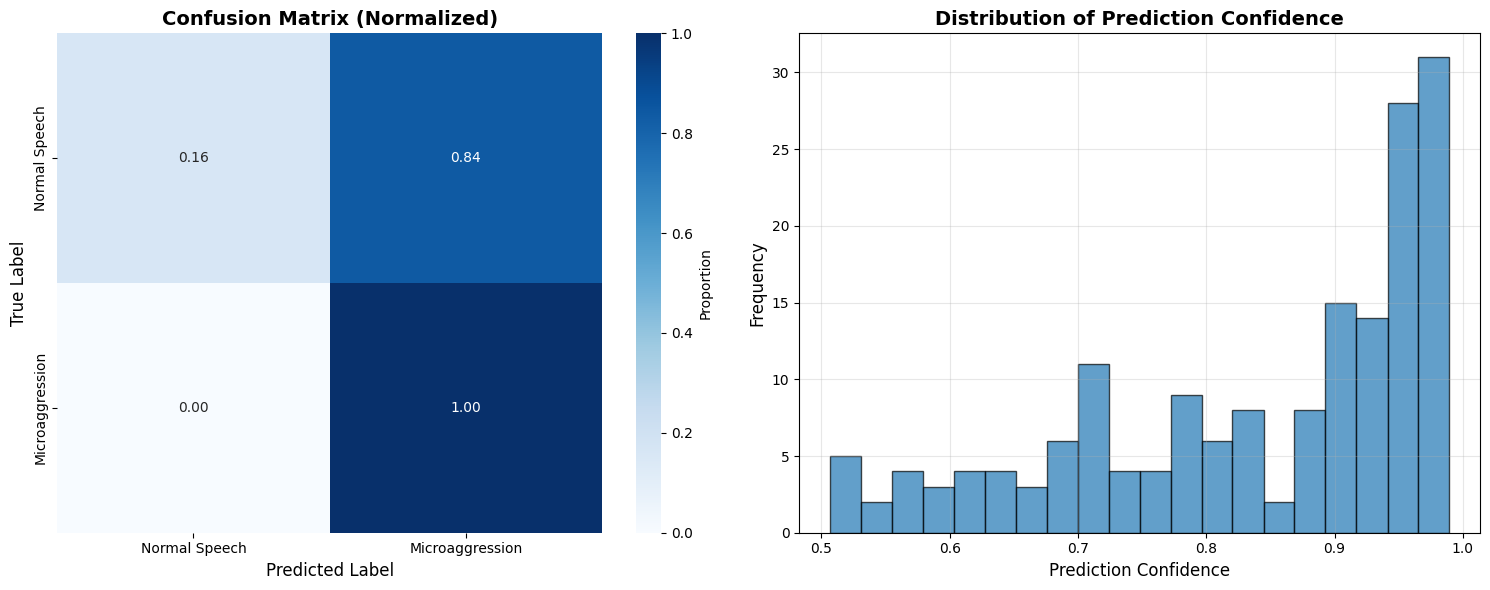


Sample Predictions on Microaggressions Dataset

Sample predictions (showing 8 examples):

✅ Example 1:
   Text: You're very articulate for someone like you.
   True: Microaggression | Predicted: Microaggression (confidence: 0.972)

✅ Example 2:
   Text: Where are you really from?
   True: Microaggression | Predicted: Microaggression (confidence: 0.964)

✅ Example 3:
   Text: You're not like other girls.
   True: Microaggression | Predicted: Microaggression (confidence: 0.988)

✅ Example 4:
   Text: You must be good at math since you're Asian.
   True: Microaggression | Predicted: Microaggression (confidence: 0.965)

✅ Example 5:
   Text: You're too pretty to be a software engineer.
   True: Microaggression | Predicted: Microaggression (confidence: 0.875)

✅ Example 6:
   Text: Are you sure you want to lead this project?
   True: Microaggression | Predicted: Microaggression (confidence: 0.954)

✅ Example 7:
   Text: You don't look gay.
   True: Microaggression | Predicted: Microaggress

In [ ]:
# Evaluate our trained CNN model on the microaggressions dataset
print("="*60)
print("Cross-Dataset Evaluation: CNN Model on Microaggressions")
print("="*60)

# Load the best trained model
print("Loading the best trained CNN model...")
try:
    # Try to load the optimized model first
    cross_eval_model = tf.keras.models.load_model('best_cnn_optimized.keras')
    print("✅ Loaded optimized CNN model")
except:
    try:
        # Fallback to baseline model
        cross_eval_model = tf.keras.models.load_model('best_cnn_baseline.keras')
        print("✅ Loaded baseline CNN model")
    except:
        print("❌ Could not load saved model. Using the final_model from training.")
        cross_eval_model = final_model

# Make predictions on microaggressions dataset
print(f"\nMaking predictions on {len(X_micro_padded)} microaggression samples...")
y_micro_pred_probs = cross_eval_model.predict(X_micro_padded, verbose=1)
y_micro_pred = np.argmax(y_micro_pred_probs, axis=1)

# Calculate metrics
if len(np.unique(y_micro_encoded)) == 2:  # Binary classification
    # For binary classification, we can calculate standard metrics
    micro_accuracy = accuracy_score(y_micro_encoded, y_micro_pred)
    micro_precision = precision_score(y_micro_encoded, y_micro_pred, average='weighted', zero_division=0)
    micro_recall = recall_score(y_micro_encoded, y_micro_pred, average='weighted', zero_division=0)
    micro_f1 = f1_score(y_micro_encoded, y_micro_pred, average='weighted', zero_division=0)

    print(f"\nCross-Dataset Performance Metrics:")
    print(f"  Accuracy:  {micro_accuracy:.4f}")
    print(f"  Precision: {micro_precision:.4f}")
    print(f"  Recall:    {micro_recall:.4f}")
    print(f"  F1 Score:  {micro_f1:.4f}")

    # Per-class metrics
    print(f"\nPer-Class Metrics:")
    print(classification_report(
        y_micro_encoded,
        y_micro_pred,
        target_names=['Normal Speech', 'Microaggression'],
        digits=4
    ))

    # Create visualizations
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Confusion Matrix
    cm = confusion_matrix(y_micro_encoded, y_micro_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=['Normal Speech', 'Microaggression'],
                yticklabels=['Normal Speech', 'Microaggression'],
                ax=axes[0], cbar_kws={'label': 'Proportion'})
    axes[0].set_title('Confusion Matrix (Normalized)', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('True Label', fontsize=12)
    axes[0].set_xlabel('Predicted Label', fontsize=12)

    # Prediction confidence distribution
    confidence_scores = np.max(y_micro_pred_probs, axis=1)
    axes[1].hist(confidence_scores, bins=20, alpha=0.7, edgecolor='black')
    axes[1].set_xlabel('Prediction Confidence', fontsize=12)
    axes[1].set_ylabel('Frequency', fontsize=12)
    axes[1].set_title('Distribution of Prediction Confidence', fontsize=14, fontweight='bold')
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

else:
    print("Multi-class classification detected. Using multi-class metrics...")
    micro_accuracy = accuracy_score(y_micro_encoded, y_micro_pred)
    micro_precision = precision_score(y_micro_encoded, y_micro_pred, average='weighted', zero_division=0)
    micro_recall = recall_score(y_micro_encoded, y_micro_pred, average='weighted', zero_division=0)
    micro_f1 = f1_score(y_micro_encoded, y_micro_pred, average='weighted', zero_division=0)

    print(f"\nCross-Dataset Performance Metrics:")
    print(f"  Accuracy:  {micro_accuracy:.4f}")
    print(f"  Precision: {micro_precision:.4f}")
    print(f"  Recall:    {micro_recall:.4f}")
    print(f"  F1 Score:  {micro_f1:.4f}")

# Show some prediction examples
print(f"\n" + "="*60)
print("Sample Predictions on Microaggressions Dataset")
print("="*60)

num_examples = 8
print(f"\nSample predictions (showing {num_examples} examples):")
for i in range(min(num_examples, len(df_micro))):
    true_label = df_micro.iloc[i]['label']
    pred_label = y_micro_pred[i]
    confidence = y_micro_pred_probs[i][pred_label]
    text = df_micro.iloc[i]['speech']

    # Map labels to readable format
    true_label_text = "Microaggression" if true_label == 1 else "Normal Speech"
    pred_label_text = "Microaggression" if pred_label == 1 else "Normal Speech"

    # Color coding for correct/incorrect predictions
    status = "✅" if true_label == pred_label else "❌"

    print(f"\n{status} Example {i+1}:")
    print(f"   Text: {text}")
    print(f"   True: {true_label_text} | Predicted: {pred_label_text} (confidence: {confidence:.3f})")



Evaluating Final Model on Test Set
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step

Test Set Metrics:
  Accuracy:  0.7308
  Precision: 0.7881
  Recall:    0.7308
  F1 Score:  0.7167

Per-Class Metrics:
              precision    recall  f1-score   support

           0     0.9167    0.5077    0.6535       130
           1     0.6596    0.9538    0.7799       130

    accuracy                         0.7308       260
   macro avg     0.7881    0.7308    0.7167       260
weighted avg     0.7881    0.7308    0.7167       260



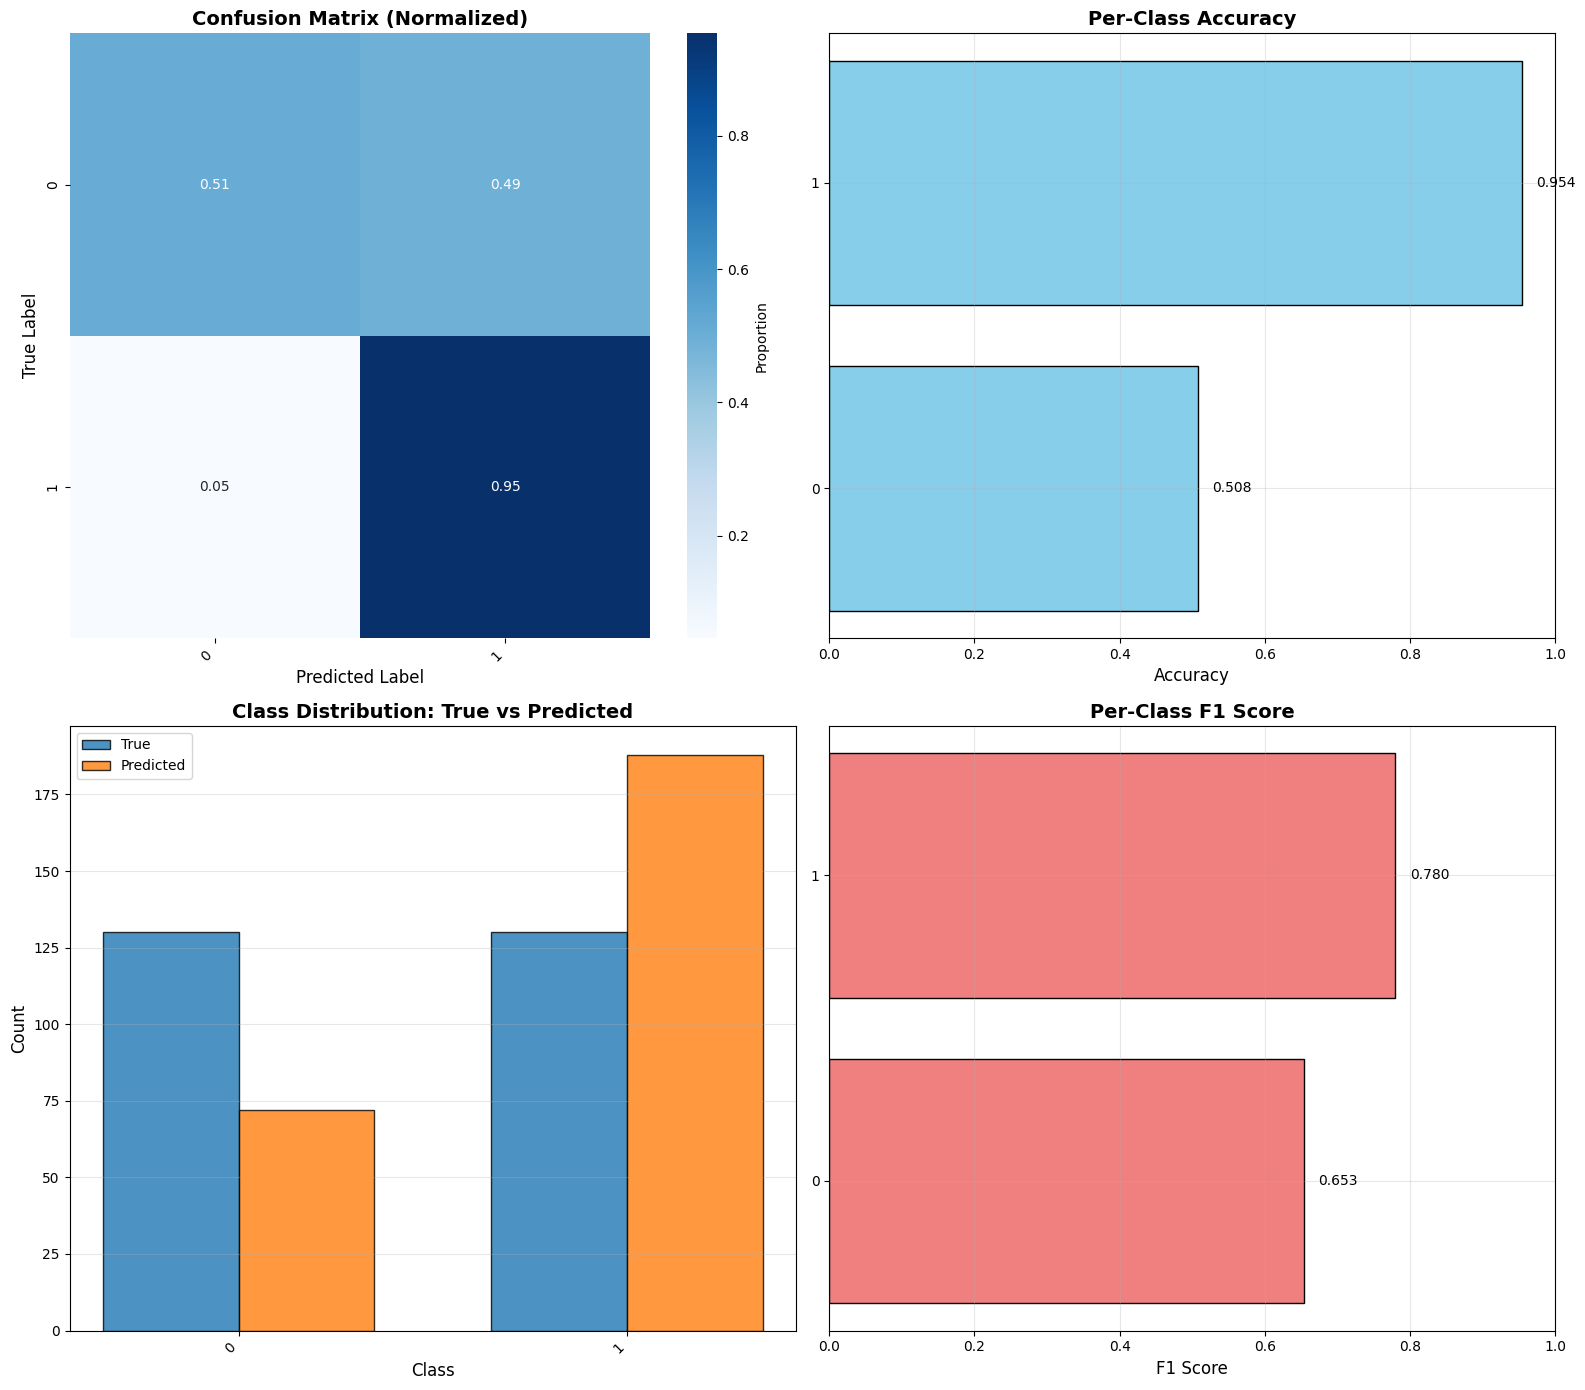


Evaluation results saved!


In [ ]:
# Comprehensive Model Evaluation on Test Set
print("\n" + "="*60)
print("Evaluating Final Model on Test Set")
print("="*60)

# Make predictions on test set
y_test_pred_probs = final_model.predict(X_test_padded)
y_test_pred = np.argmax(y_test_pred_probs, axis=1)

# Calculate metrics
test_accuracy = accuracy_score(y_test_encoded, y_test_pred)
test_precision = precision_score(y_test_encoded, y_test_pred, average='weighted', zero_division=0)
test_recall = recall_score(y_test_encoded, y_test_pred, average='weighted', zero_division=0)
test_f1 = f1_score(y_test_encoded, y_test_pred, average='weighted', zero_division=0)

print(f"\nTest Set Metrics:")
print(f"  Accuracy:  {test_accuracy:.4f}")
print(f"  Precision: {test_precision:.4f}")
print(f"  Recall:    {test_recall:.4f}")
print(f"  F1 Score:  {test_f1:.4f}")

# Per-class metrics
print(f"\nPer-Class Metrics:")
print(classification_report(
    y_test_encoded,
    y_test_pred,
    target_names=[str(c) for c in label_encoder.classes_], # Convert class names to strings
    digits=4
))

# Create comprehensive evaluation visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# 1. Confusion Matrix
cm = confusion_matrix(y_test_encoded, y_test_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=[str(c) for c in label_encoder.classes_],
            yticklabels=[str(c) for c in label_encoder.classes_],
            ax=axes[0, 0], cbar_kws={'label': 'Proportion'})
axes[0, 0].set_title('Confusion Matrix (Normalized)', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('True Label', fontsize=12)
axes[0, 0].set_xlabel('Predicted Label', fontsize=12)
plt.setp(axes[0, 0].xaxis.get_majorticklabels(), rotation=45, ha='right')

# 2. Per-class accuracy
class_accuracies = []
for i in range(len(label_encoder.classes_)):
    mask = y_test_encoded == i
    if mask.sum() > 0:
        class_acc = (y_test_pred[mask] == i).sum() / mask.sum()
        class_accuracies.append(class_acc)
    else:
        class_accuracies.append(0)

axes[0, 1].barh([str(c) for c in label_encoder.classes_], class_accuracies, color='skyblue', edgecolor='black')
axes[0, 1].set_xlabel('Accuracy', fontsize=12)
axes[0, 1].set_title('Per-Class Accuracy', fontsize=14, fontweight='bold')
axes[0, 1].set_xlim([0, 1])
axes[0, 1].grid(True, alpha=0.3)
for i, v in enumerate(class_accuracies):
    axes[0, 1].text(v + 0.02, i, f'{v:.3f}', va='center')

# 3. Class distribution comparison
class_counts_test = pd.Series(y_test_encoded).value_counts().sort_index()
class_counts_pred = pd.Series(y_test_pred).value_counts().sort_index()

x = np.arange(len(label_encoder.classes_))
width = 0.35

axes[1, 0].bar(x - width/2, [class_counts_test.get(i, 0) for i in range(len(label_encoder.classes_))],
               width, label='True', alpha=0.8, edgecolor='black')
axes[1, 0].bar(x + width/2, [class_counts_pred.get(i, 0) for i in range(len(label_encoder.classes_))],
               width, label='Predicted', alpha=0.8, edgecolor='black')

axes[1, 0].set_xlabel('Class', fontsize=12)
axes[1, 0].set_ylabel('Count', fontsize=12)
axes[1, 0].set_title('Class Distribution: True vs Predicted', fontsize=14, fontweight='bold')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels([str(c) for c in label_encoder.classes_], rotation=45, ha='right')
axes[1, 0].legend()
axes[1, 0].grid(axis='y', alpha=0.3)

# 4. F1 scores per class
from sklearn.metrics import f1_score as f1_score_func
f1_scores = []
for i in range(len(label_encoder.classes_)):
    y_true_binary = (y_test_encoded == i).astype(int)
    y_pred_binary = (y_test_pred == i).astype(int)
    f1 = f1_score_func(y_true_binary, y_pred_binary, zero_division=0)
    f1_scores.append(f1)

axes[1, 1].barh([str(c) for c in label_encoder.classes_], f1_scores, color='lightcoral', edgecolor='black')
axes[1, 1].set_xlabel('F1 Score', fontsize=12)
axes[1, 1].set_title('Per-Class F1 Score', fontsize=14, fontweight='bold')
axes[1, 1].set_xlim([0, 1])
axes[1, 1].grid(True, alpha=0.3)
for i, v in enumerate(f1_scores):
    axes[1, 1].text(v + 0.02, i, f'{v:.3f}', va='center')

plt.tight_layout()
plt.show()

# Save evaluation results
eval_results = {
    'test_accuracy': test_accuracy,
    'test_precision': test_precision,
    'test_recall': test_recall,
    'test_f1': test_f1,
    'per_class_accuracy': dict(zip(label_encoder.classes_, class_accuracies)),
    'per_class_f1': dict(zip(label_encoder.classes_, f1_scores))
}

print(f"\nEvaluation results saved!")


In [ ]:
# Analysis and Insights from Cross-Dataset Evaluation
print("="*60)
print("Cross-Dataset Analysis and Insights")
print("="*60)

# Compare performance between original and cross-dataset evaluation
print(f"\nPerformance Comparison:")
print(f"  Original Dataset Test Set:")
print(f"    Accuracy:  {test_accuracy:.4f}")
print(f"    F1 Score:  {test_f1:.4f}")
print(f"  Microaggressions Dataset:")
print(f"    Accuracy:  {micro_accuracy:.4f}")
print(f"    F1 Score:  {micro_f1:.4f}")

# Calculate performance drop
accuracy_drop = test_accuracy - micro_accuracy
f1_drop = test_f1 - micro_f1

print(f"\nPerformance Analysis:")
print(f"  Accuracy drop: {accuracy_drop:.4f} ({accuracy_drop/test_accuracy*100:.1f}%)")
print(f"  F1 Score drop: {f1_drop:.4f} ({f1_drop/test_f1*100:.1f}%)")

# Analyze prediction patterns
print(f"\nPrediction Pattern Analysis:")

# Count correct vs incorrect predictions
correct_predictions = np.sum(y_micro_encoded == y_micro_pred)
incorrect_predictions = len(y_micro_encoded) - correct_predictions

print(f"  Total samples: {len(y_micro_encoded)}")
print(f"  Correct predictions: {correct_predictions} ({correct_predictions/len(y_micro_encoded)*100:.1f}%)")
print(f"  Incorrect predictions: {incorrect_predictions} ({incorrect_predictions/len(y_micro_encoded)*100:.1f}%)")

# Analyze confidence scores
confidence_scores = np.max(y_micro_pred_probs, axis=1)
high_confidence = np.sum(confidence_scores > 0.8)
medium_confidence = np.sum((confidence_scores > 0.5) & (confidence_scores <= 0.8))
low_confidence = np.sum(confidence_scores <= 0.5)

print(f"\nConfidence Analysis:")
print(f"  High confidence (>0.8): {high_confidence} ({high_confidence/len(confidence_scores)*100:.1f}%)")
print(f"  Medium confidence (0.5-0.8): {medium_confidence} ({medium_confidence/len(confidence_scores)*100:.1f}%)")
print(f"  Low confidence (≤0.5): {low_confidence} ({low_confidence/len(confidence_scores)*100:.1f}%)")

# Analyze errors by class
print(f"\nError Analysis by Class:")
for true_class in [0, 1]:
    class_mask = y_micro_encoded == true_class
    class_predictions = y_micro_pred[class_mask]
    class_accuracy = np.sum(class_predictions == true_class) / np.sum(class_mask)

    class_name = "Normal Speech" if true_class == 0 else "Microaggression"
    print(f"  {class_name} (Class {true_class}): {class_accuracy:.3f} accuracy")

# Show most confident incorrect predictions
print(f"\nMost Confident Incorrect Predictions:")
incorrect_mask = y_micro_encoded != y_micro_pred
if np.any(incorrect_mask):
    incorrect_indices = np.where(incorrect_mask)[0]
    incorrect_confidences = confidence_scores[incorrect_mask]

    # Sort by confidence (highest first)
    sorted_indices = np.argsort(incorrect_confidences)[::-1]

    print("  (These are cases where the model was very confident but wrong)")
    for i in range(min(3, len(sorted_indices))):
        idx = incorrect_indices[sorted_indices[i]]
        true_label = df_micro.iloc[idx]['label']
        pred_label = y_micro_pred[idx]
        confidence = confidence_scores[idx]
        text = df_micro.iloc[idx]['speech']

        true_label_text = "Microaggression" if true_label == 1 else "Normal Speech"
        pred_label_text = "Microaggression" if pred_label == 1 else "Normal Speech"

        print(f"\n  {i+1}. Confidence: {confidence:.3f}")
        print(f"     Text: {text}")
        print(f"     True: {true_label_text} | Predicted: {pred_label_text}")

print(f"\n" + "="*60)
print("Key Insights:")
print("="*60)
print("1. Cross-dataset evaluation helps assess model generalization")
print("2. Performance drop indicates domain-specific learning")
print("3. Low confidence predictions may indicate out-of-domain samples")
print("4. Error analysis reveals model biases and limitations")
print("5. This evaluation is crucial for real-world deployment")


Cross-Dataset Analysis and Insights

Performance Comparison:
  Original Dataset Test Set:
    Accuracy:  0.7308
    F1 Score:  0.7167
  Microaggressions Dataset:
    Accuracy:  0.5731
    F1 Score:  0.4835

Performance Analysis:
  Accuracy drop: 0.1577 (21.6%)
  F1 Score drop: 0.2332 (32.5%)

Prediction Pattern Analysis:
  Total samples: 171
  Correct predictions: 98 (57.3%)
  Incorrect predictions: 73 (42.7%)

Confidence Analysis:
  High confidence (>0.8): 112 (65.5%)
  Medium confidence (0.5-0.8): 59 (34.5%)
  Low confidence (≤0.5): 0 (0.0%)

Error Analysis by Class:
  Normal Speech (Class 0): 0.161 accuracy
  Microaggression (Class 1): 1.000 accuracy

Most Confident Incorrect Predictions:
  (These are cases where the model was very confident but wrong)

  1. Confidence: 0.964
     Text: Could you add a bit more detail here?
     True: Normal Speech | Predicted: Microaggression

  2. Confidence: 0.957
     Text: Ping me if you face any blockers.
     True: Normal Speech | Predicted: 